In [ ]:
!pip install annoy
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 10.0 MB/s eta 0:00:00


In [ ]:
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import zipfile
import os
from PIL import Image
import torchvision.transforms as T

import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
import time
import copy

import torchvision.models as models
import torchvision.transforms as transforms
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchmetrics


In [ ]:
%matplotlib inline

In [ ]:
train_on_gpu = torch.cuda.is_available()

In [ ]:
# Загрузка данных от DeepFashion
url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pWnFiNlNGTVloLUk'
output = 'list_category_cloth.txt'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pTGNoWkhZeVpzbFk'
output = 'list_category_img.txt'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pdS1FMlNreEwtc1E'
output = 'list_eval_partition.txt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pWnFiNlNGTVloLUk
To: /content/list_category_cloth.txt
100%|██████████| 882/882 [00:00<00:00, 1.68MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pTGNoWkhZeVpzbFk
To: /content/list_category_img.txt
100%|██████████| 21.4M/21.4M [00:00<00:00, 177MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pdS1FMlNreEwtc1E
To: /content/list_eval_partition.txt
100%|██████████| 22.2M/22.2M [00:00<00:00, 122MB/s] 


'list_eval_partition.txt'

In [ ]:
# Загрузка изображений (289222 объекта)
root_path = './'
url = 'https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb'
output = 'images.zip'
gdown.download(url, output, quiet=False)

with zipfile.ZipFile("images.zip","r") as zip_ref:
    zip_ref.extractall(root_path)
  


Downloading...
From: https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb
To: /content/images.zip
100%|██████████| 2.68G/2.68G [00:21<00:00, 124MB/s]


In [ ]:
# Получение метаданных об изображениях
category_list = []
image_path_list = []
data_type_list = []

# Название категорий одежды
with open('list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_list.append(line.split(' ')[0])

# Пути к файлам
with open('list_category_img.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            image_path_list.append([word.strip() for word in line.split(' ') if len(word) > 0])


# Деление на train, valid, test
with open('list_eval_partition.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            data_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [ ]:
# Dataframe с полученной инф. об изображениях
data_df = pd.DataFrame(image_path_list, columns=['image_path', 'category_number'])
data_df['category_number'] = data_df['category_number'].astype(int)
data_df = data_df.merge(pd.DataFrame(data_type_list, columns=['image_path', 'dataset_type']), on='image_path')
data_df['category'] = data_df['category_number'].apply(lambda x: category_list[int(x) - 1])
data_df = data_df.drop('category_number', axis=1)
data_df.head()

,image_path,dataset_type,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test,Blouse


In [ ]:
# Количество уникальных категорий одежды в датасете
len(data_df.category.unique())

46

In [ ]:
# Создает словарь: ключ (int): категория (str)
category_strs = [x for x in data_df.category.unique()]

category_dict = {category_strs[i]: i  for i in range(len(data_df.category.unique()))}
category_dict_reversed = {i: category_strs[i]  for i in range(len(data_df.category.unique()))}


In [ ]:
# Данные несбалансированны, стоит учесть
data_df[['image_path','category']].groupby('category').count()

,image_path
category,
Anorak,160
Blazer,7495
Blouse,24557
Bomber,309
Button-Down,330
Caftan,54
Capris,77
Cardigan,13311
Chinos,527


In [ ]:
# Заменяем строковые категории на числа в соответствие словарю
data_df["category"] = data_df["category"].apply(lambda x: category_dict[x])
data_df

,image_path,dataset_type,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train,0
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train,0
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val,0
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train,0
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test,0
...,...,...,...
289217,img/Paisley_Print_Babydoll_Dress/img_00000050.jpg,train,36
289218,img/Paisley_Print_Babydoll_Dress/img_00000051.jpg,train,36
289219,img/Paisley_Print_Babydoll_Dress/img_00000052.jpg,train,36
289220,img/Paisley_Print_Babydoll_Dress/img_00000053.jpg,train,36


In [ ]:
# Класс датасета, который используется для обучения
class DeepFashionDataset(torch.utils.data.Dataset):
  def __init__(self, data_df, transform=None):
    self.img_labels = data_df["category"]
    self.img_paths = data_df["image_path"]
    self.transform = transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = self.img_paths.iloc[idx]
    image = Image.open(img_path)
    label = self.img_labels.iloc[idx]
    if self.transform:
      image = self.transform(image)

    return image, label

In [ ]:
data_df_sample = data_df.sample(n=10000, random_state=1)

In [ ]:
train_df = data_df_sample.loc[data_df_sample["dataset_type"] == "train"]
val_df = data_df_sample.loc[data_df_sample["dataset_type"] == "val"]
test_df = data_df_sample.loc[data_df_sample["dataset_type"] == "test"]

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
workers = 2

train_dataset = DeepFashionDataset(train_df, data_transforms["train"])
train_dataloader = DataLoader(train_dataset, 
                              batch_size=4, 
                              shuffle=True, 
                              num_workers=workers)

val_dataset = DeepFashionDataset(val_df, data_transforms["val"])
val_dataloader = DataLoader(val_dataset, 
                              batch_size=4, 
                              shuffle=True, 
                              num_workers=workers)

test_dataset = DeepFashionDataset(test_df, data_transforms["val"])
test_dataloader = DataLoader(test_dataset, 
                              batch_size=4, 
                              shuffle=True, 
                              num_workers=workers)

dataloaders = {"train": train_dataloader,
               "val": val_dataloader,
               "test": test_dataloader}

dataset_sizes = {"train": len(train_dataset),
                 "val": len(val_dataset),
                 "test": len(test_dataset)}


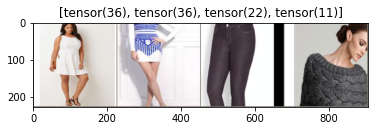

In [ ]:
# Выводит изображение
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


# Получает батч для обучения
inputs, classes = next(iter(train_dataloader))

# Делает сетку для вывода
out = torchvision.utils.make_grid(inputs)

# Выводит изображения и классы из датасета
imshow(out, title=[x for x in classes])

In [ ]:
# Если cuda есть, то использует
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Обучает модель
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Каждая эпоха обучается и проходит валидацию
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Режим для обучения
            else:
                model.eval()   # Режим для просмотра вывода

            running_loss = 0.0
            running_corrects = 0


            # Проходит по всем данным
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                # Обнуляет градиент
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Сохраняет лучшую модель
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Обучение завершилось за {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Лучшее значение accuracy: {best_acc:4f}')

    # Загружает лучшую модель и возвращает её
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

                ax.set_title(f'predicted: {category_dict_reversed[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(data_df.category.unique()))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Каждые 7 шагов уменьшает lr
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


<ipython-input-66-bd220c3bd893>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


train Loss: 2.6684 Acc: 0.2722
val Loss: 2.2304 Acc: 0.4046

Epoch 1/24
----------
train Loss: 2.4025 Acc: 0.3271
val Loss: 2.1784 Acc: 0.4402

Epoch 2/24
----------
train Loss: 2.2479 Acc: 0.3601
val Loss: 1.8548 Acc: 0.4965

Epoch 3/24
----------
train Loss: 2.1533 Acc: 0.3868
val Loss: 1.8454 Acc: 0.4981

Epoch 4/24
----------
train Loss: 2.0771 Acc: 0.4085
val Loss: 1.9842 Acc: 0.4602

Epoch 5/24
----------
train Loss: 2.0221 Acc: 0.4246
val Loss: 1.7758 Acc: 0.5066

Epoch 6/24
----------
train Loss: 1.9641 Acc: 0.4355
val Loss: 1.7746 Acc: 0.5220

Epoch 7/24
----------
train Loss: 1.7442 Acc: 0.5012
val Loss: 1.6520 Acc: 0.5544

Epoch 8/24
----------
train Loss: 1.6743 Acc: 0.5147
val Loss: 1.6913 Acc: 0.5598

Epoch 9/24
----------
train Loss: 1.6412 Acc: 0.5271
val Loss: 1.6513 Acc: 0.5475

Epoch 10/24
----------
train Loss: 1.6045 Acc: 0.5341
val Loss: 1.6497 Acc: 0.5637

Epoch 11/24
----------
train Loss: 1.6128 Acc: 0.5363
val Loss: 1.6471 Acc: 0.5568

Epoch 12/24
----------
t

In [ ]:
torch.save(model_ft.state_dict(), "model_ft_10kSGD_25epochs")

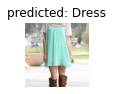

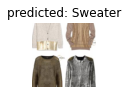

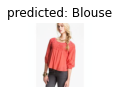

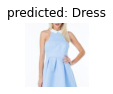

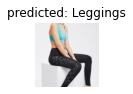

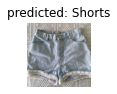

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [ ]:
# Получает предсказания по данным df 
def get_output(model, data_df):
  
  pred_labels = []

  for image_path in data_df["image_path"]:
    model.eval()

    with torch.no_grad():
      model.eval()

      transform = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

      # Загружается изображение и трансформируется.
      image = Image.open(image_path)
      image = transform(image).float()

      image = image.unsqueeze(0)
      image = image.to(device)

      output = model(image)
      _, preds = torch.max(output, 1)

      pred_labels.append(preds.item())

  return np.array(pred_labels)

test_output = get_output(model_ft, test_df)

In [ ]:
test_output_df["predictions"] = test_output
test_output_df["ground_true"] = test_df["category"].to_numpy()

In [ ]:
test_output_df

,predictions,ground_true
0,23,29
1,36,36
2,36,36
3,36,36
4,11,20
...,...,...
1368,23,23
1369,0,7
1370,0,2
1371,22,24


In [ ]:
len(test_output_df[test_output_df["predictions"] == test_output_df["ground_true"]])

752

In [ ]:
preds = torch.tensor(test_output_df["predictions"].values)
target = torch.tensor(test_output_df["ground_true"].values)

In [ ]:
import sklearn.metrics as skmetrics

print("Accuracy:", skmetrics.accuracy_score(preds, target))
print("Precision", skmetrics.precision_score(preds, target, average="weighted"))
print("Recall", skmetrics.recall_score(preds, target, average="weighted"))
print("F1 Score:", skmetrics.f1_score(preds, target, average="weighted"))


In [ ]:
def get_metrics(model):
    model.eval()
    images_so_far = 0
    num_images = 6

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1

                print(category_dict_reversed[preds[j].item()], preds[j])
                print(category_dict_reversed[labels[j].item()], labels[j])
                print()

                if images_so_far == num_images:
                    return   


get_metrics(model_ft)

Shorts tensor(21, device='cuda:0')
Shorts tensor(21)

Shorts tensor(21, device='cuda:0')
Shorts tensor(21)

Dress tensor(36, device='cuda:0')
Dress tensor(36)

Jacket tensor(12, device='cuda:0')
Jacket tensor(12)

Blouse tensor(0, device='cuda:0')
Blouse tensor(0)

Dress tensor(36, device='cuda:0')
Dress tensor(36)



In [ ]:
# Загрузка модели из файла
# model_load = torchvision.models.resnet18(pretrained=True)
# for param in model_load.parameters():
#     param.requires_grad = False

# num_ftrs = model_load.fc.in_features
# model_load.fc = nn.Linear(num_ftrs, len(data_df.category.unique()))

# model_load = model_load.to(device)
# model_load.load_state_dict(torch.load("model_ft_10kSGD"))
# model = model_load

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model = model_ft

for param in model.parameters():
    param.requires_grad = False


In [ ]:
# Возвращает векторное представление изображения.
def get_embedding(model, image_path):
  # Удаляет у модели последний слой, чтобы получить признаки перед ним.
  model = torch.nn.Sequential(*list(model.children())[:-1])

  model.eval()

  transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  # Загружается изображение и трансформируется.
  image = Image.open(image_path)
  image = transform(image).float()

  image = image.unsqueeze(0)
  image = image.to(device)

  # Получение признаков изображения из модели.
  embedding = model(image)

  return embedding.flatten().cpu().numpy()

In [ ]:
a = get_embedding(model, 'img/1981_Graphic_Ringer_Tee/img_00000001.jpg')
print(type(a[0]))

<class 'numpy.float32'>


In [ ]:
data_df_sample = data_df.sample(n=10000, random_state=1)

In [ ]:
data_df_sample["embedding"] = data_df_sample.apply(lambda row : get_embedding(model, row["image_path"]), axis=1)

In [ ]:
data_df_sample.to_csv("!data_df_sample_10k_train25epochs.csv", index=False)

In [ ]:
data_df_sample

,image_path,dataset_type,category,embedding
131971,img/Raglan_Pocket_Tee/img_00000021.jpg,train,5,"[0.7801929, 0.38059583, 1.1513234, 0.57616985,..."
165076,img/Kaleidoscope_Print_Culottes/img_00000007.jpg,test,29,"[0.8950049, 0.12929729, 0.27530184, 1.2924576,..."
147455,img/Button-Tab_Ankle_Chinos/img_00000031.jpg,train,30,"[0.024734756, 0.16383418, 1.6474096, 1.0562536..."
220005,img/Elegant_Crochet_Lace_Dress/img_00000011.jpg,test,36,"[0.9829293, 0.69318676, 1.0941569, 1.0361465, ..."
242732,img/Leopard_Print_Maxi_Dress/img_00000083.jpg,train,36,"[0.2262318, 1.1563926, 0.5175845, 0.76782334, ..."
...,...,...,...,...
235022,img/Floral_Print_Strapless_Dress/img_00000003.jpg,train,36,"[1.9360924, 1.3751831, 1.0923586, 1.7844723, 0..."
177983,img/Reverse-Paneled_French_Terry_Sweatpants/im...,test,24,"[1.5142595, 0.5125311, 0.24266905, 1.1337814, ..."
64349,img/Chiffon_Maxi_Cardigan/img_00000067.jpg,train,11,"[0.23183835, 0.56334966, 0.27694207, 2.2508857..."
277512,img/Metallic_Slip_Dress/img_00000068.jpg,val,36,"[1.0065583, 0.9728157, 0.5898564, 1.750377, 1...."


In [ ]:
# Использует Spotify Annoy для поиска похожих по id
def get_similar_images_annoy(annoy_tree, img_index, number_of_items=12):
    start = time.time()
    img_id, img_label  = data_df_sample.iloc[img_index, [0, 1]]
    similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')

    return img_id, img_label, data_df_sample.iloc[similar_img_ids[1:]] 


# Получает похожие по вектору изображения
def get_similar_images_annoy_centroid(annoy_tree, vector_value, number_of_items=12):
    start = time.time()
    similar_img_ids = annoy_tree.get_nns_by_vector(vector_value, number_of_items+1)
    end = time.time()

    # Выводит время выполнения алгоритма.
    print(f'{(end - start) * 1000} ms')

    # Первый элемент пропускается, т. к. это само изображение
    return data_df_sample.iloc[similar_img_ids[1:]] 


In [ ]:
# Больше деревьев даст большее приближение.
ntree = 100

# Также доступны: "angular", "euclidean", "manhattan", "hamming", "dot"
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(data_df_sample['embedding'].iloc[0]), metric=metric_choice)

for i, vector in enumerate(data_df_sample['embedding']):
    annoy_tree.add_item(i, vector)

_ = annoy_tree.build(ntree)

In [ ]:
def centroid_embedding(outfit_embedding_list):
    number_of_outfits = outfit_embedding_list.shape[0]
    length_of_embedding = outfit_embedding_list.shape[1]
    centroid = []
    for i in range(length_of_embedding):
        centroid.append(np.sum(outfit_embedding_list[:, i])/number_of_outfits)
    return centroid

8785


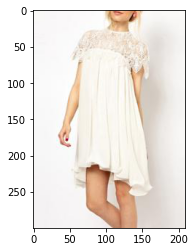

In [ ]:
img_index = np.random.randint(len(data_df_sample), size=1)[0]
print(img_index)
rand_image_path = data_df_sample["image_path"].iloc[img_index]

img = mpimg.imread(rand_image_path)
imgplot = plt.imshow(img)
plt.show()

3947
img/Faded_Denim_Cutoffs/img_00000035.jpg


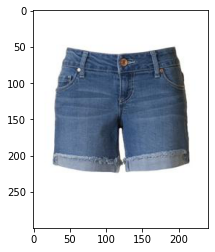

In [ ]:
img_index = np.random.randint(len(data_df_sample), size=1)[0]
print(img_index)
rand_image_path = data_df_sample["image_path"].iloc[img_index]

img = mpimg.imread(rand_image_path)
print(rand_image_path)
imgplot = plt.imshow(img)
plt.show()

In [ ]:
# Id платьев в датасете.
# outfit_img_ids = [8785, 4115, 8383, 137, 3939, 6666, 7781]

# Id шорт в датасете.
outfit_img_ids = [3119, 4648, 7489, 4581, 387, 8179, 538]

outfit_embedding_list = []

for img_index in outfit_img_ids:
    outfit_embedding_list.append(data_df_sample["embedding"].iloc[img_index])

outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = data_df_sample.iloc[outfit_img_ids] 

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 10)

0.6699562072753906 ms


In [ ]:
similar_images_list = list(similar_images_df["image_path"])

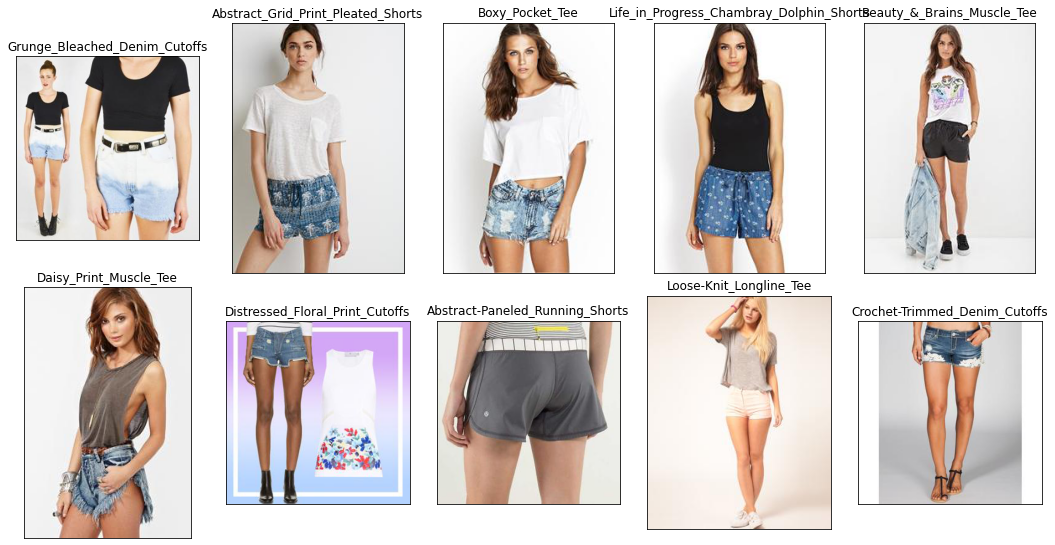

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5)

for i, ax in enumerate(axs.flatten()):
    img = Image.open(similar_images_list[i])
    ax.imshow(img)
    ax.set_title(similar_images_list[i].split("/")[-2])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.tight_layout()
fig.set_size_inches(15, 8)

# Выводит все похожие изображения.
plt.show()
